In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

'c:\\Users\\Joaquín Amat\\Documents\\GitHub\\skforecast'

In [2]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
from pprint import pprint
from skforecast.datasets import fetch_dataset


# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
pio.renderers.default = 'notebook' 
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')
from skforecast.plot import plot_residuals

# Modelling and Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster


# Warnings configuration
# ==============================================================================
import warnings

c:\anaconda\envs\skforecast_11_py12\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [3]:
# Downloading data
# ==============================================================================
data = pd.read_csv(
    "https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast-datasets/main/data/bike_sharing_extended_features.csv"
)

In [4]:
# Preprocessing data (setting index and frequency)
# ==============================================================================
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('date_time')
data = data.asfreq('H')
data = data.sort_index()
data = data.astype({col: np.float32 for col in data.select_dtypes("number").columns})
data.head(2)

users weather  month_sin  month_cos  week_of_year_sin  \
date_time                                                                    
2011-01-08 00:00:00   25.0    mist        0.5   0.866025          0.120537   
2011-01-08 01:00:00   16.0    mist        0.5   0.866025          0.120537   

                     week_of_year_cos  week_day_sin  week_day_cos  \
date_time                                                           
2011-01-08 00:00:00          0.992709     -0.781832       0.62349   
2011-01-08 01:00:00          0.992709     -0.781832       0.62349   

                     hour_day_sin  hour_day_cos  ...  temp_roll_mean_1_day  \
date_time                                        ...                         
2011-01-08 00:00:00      0.258819      0.965926  ...              8.063334   
2011-01-08 01:00:00      0.500000      0.866025  ...              8.029166   

                     temp_roll_mean_7_day  temp_roll_max_1_day  \
date_time                                                        
2011-01-08 00:00:00             10.127976                 9.02   
2011-01-08 01:00:00             10.113334                 9.02   

                     temp_roll_min_1_day  temp_roll_max_7_day  \
date_time                                                       
2011-01-08 00:00:00                 6.56            18.860001   
2011-01-08 01:00:00                 6.56            18.860001   

                     temp_roll_min_7_day  holiday_previous_day  \
date_time                                                        
2011-01-08 00:00:00                 4.92                   0.0   
2011-01-08 01:00:00                 4.92                   0.0   

                     holiday_next_day  temp  holiday  
date_time                                             
2011-01-08 00:00:00               0.0  7.38      0.0  
2011-01-08 01:00:00               0.0  7.38      0.0  

[2 rows x 90 columns]

In [5]:
# One hot encoding of categorical variable weather
# ==============================================================================
encoder = ColumnTransformer(
            [('one_hot_encoder', OneHotEncoder(sparse_output=False), ['weather'])],
            remainder='passthrough',
            verbose_feature_names_out=False
         ).set_output(transform="pandas")
data = encoder.fit_transform(data)

In [6]:
# Select exogenous variables to be included in the model
# ==============================================================================
exog_features = [
    'weather_clear', 'weather_mist', 'weather_rain', 'week_of_year_sin',
    'week_of_year_cos', 'hour_day_sin', 'hour_day_cos', 
    'poly_month_sin__hour_day_sin', 'poly_month_sin__week_of_year_sin',
    'poly_week_of_year_sin__week_day_sin','poly_month_sin__hour_day_cos',
    'poly_week_of_year_sin__hour_day_sin',
    'poly_week_of_year_cos__week_day_sin',
    'poly_week_of_year_cos__week_day_cos',
    'poly_week_of_year_cos__hour_day_sin',
    'poly_week_of_year_cos__hour_day_cos',
    'poly_week_of_year_cos__sunset_hour_cos',
    'poly_week_day_sin__week_day_cos', 'poly_week_day_sin__hour_day_sin',
    'poly_week_day_sin__hour_day_cos', 'poly_week_day_sin__sunset_hour_sin',
    'poly_week_day_cos__hour_day_sin', 'poly_week_day_cos__hour_day_cos',
    'poly_hour_day_sin__hour_day_cos', 'poly_hour_day_sin__sunset_hour_sin',
    'poly_hour_day_cos__sunset_hour_sin', 'temp'
 ]

data = data[['users'] + exog_features]

To facilitate the training of the models, the search for optimal hyperparameters and the evaluation of their predictive accuracy, the data are divided into three separate sets: training, validation and test.

In [7]:
# Split train-validation-test
# ==============================================================================
end_train = '2012-07-31 23:59:00'
end_validation = '2012-09-30 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2011-01-08 00:00:00 --- 2012-07-31 23:00:00  (n=13704)
Dates validacion : 2012-08-01 00:00:00 --- 2012-09-30 23:00:00  (n=1464)
Dates test       : 2012-10-01 00:00:00 --- 2012-12-30 23:00:00  (n=2184)


In [8]:
# Interactive plot of time series
# ==============================================================================
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_train.index, y=data_train['users'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=data_val.index, y=data_val['users'], mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=data_test.index, y=data_test['users'], mode='lines', name='Test'))
fig.update_layout(
    title  = 'Number of users',
    xaxis_title="Time",
    yaxis_title="Users",
    legend_title="Partition:",
    width=900,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
#fig.update_xaxes(rangeslider_visible=True)
fig.show()

## Prediction intervals

In [9]:
# Create forecaster with the selected features
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = Ridge(),
                 lags = [1, 2, 3, 23, 24, 25, 167, 168, 169]
             )

In [10]:
def plot_predicted_intervals(
    predictions: pd.DataFrame,
    y_true: pd.DataFrame,
    target_variable: str,
):
    """
    Plot predicted intervals vs real values

    Parameters
    ----------
    predictions : pd.DataFrame
        Predicted values and intervals.
    y_true : pd.DataFrame
        Real values of target variable.
    target_variable : str
        Name of target variable.
    """

    fig = go.Figure([
        go.Scatter(name='Prediction', x=predictions.index, y=predictions['pred'], mode='lines'),
        go.Scatter(name='Real value', x=y_true.index, y=y_true['users'], mode='lines'),
        go.Scatter(
            name='Upper Bound', x=predictions.index, y=predictions['upper_bound'],
            mode='lines', marker=dict(color="#444"), line=dict(width=0), showlegend=False
        ),
        go.Scatter(
            name='Lower Bound', x=predictions.index, y=predictions['lower_bound'],
            marker=dict(color="#444"), line=dict(width=0), mode='lines',
            fillcolor='rgba(68, 68, 68, 0.3)', fill='tonexty', showlegend=False
        )
    ])
    fig.update_layout(
        title="Real value vs predicted in test data",
        xaxis_title="Date time",
        yaxis_title="users",
        width=900,
        height=400,
        margin=dict(l=20, r=20, t=35, b=20),
        hovermode="x",
        xaxis=dict(range=['2012-12-01', '2012-12-25']), # Initial zoom
        legend=dict(
            orientation="h",
            yanchor="top",
            y=1.1,
            xanchor="left",
            x=0.001
        )
    )
    fig.show()

## In sample residuals

By default, intervals are calculated using in-sample residuals (residuals from the training set). However, this can result in intervals that are too narrow (overly optimistic).

In [11]:
# Backtesting with prediction intervals in test data using in-sample residuals
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster          = forecaster,
                          y                   = data['users'], # Full dataset
                          exog                = data[exog_features],
                          steps               = 36,
                          metric              = 'mean_absolute_error',
                          initial_train_size  = len(data.loc[:end_validation]),
                          refit               = False,
                          interval            = [10, 90], # 80% prediction interval
                          n_boot              = 100,
                          in_sample_residuals = True, # Use in-sample residuals
                          binned_residuals    = False,
                          n_jobs              = 'auto',
                          verbose             = False,
                          show_progress       = True
                      )
predictions.head(5)

100%|██████████| 61/61 [00:31<00:00,  1.95it/s]


pred  lower_bound  upper_bound
2012-10-01 00:00:00  39.792324     2.254396    89.636567
2012-10-01 01:00:00  17.103559   -52.112413    81.453647
2012-10-01 02:00:00  13.859449   -51.782839    98.542296
2012-10-01 03:00:00  12.616873   -57.316933    85.179738
2012-10-01 04:00:00   9.853097   -76.941451    95.770179

In [12]:
# Predicted interval coverage (on test data)
# ==============================================================================
inside_interval = np.where(
                      (data.loc[end_validation:, 'users'] >= predictions["lower_bound"]) & \
                      (data.loc[end_validation:, 'users'] <= predictions["upper_bound"]),
                      True,
                      False 
                  )

coverage = inside_interval.mean()
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

# Area between the upper and lower bounds
# ==============================================================================
area = predictions['upper_bound'] - predictions['lower_bound']
area = area.sum()
print(f"Area between the upper and lower bounds: {round(area, 2)}")

# Plot
# ==============================================================================
plot_predicted_intervals(
    predictions=predictions,
    y_true=data_test,
    target_variable='users',
)

Predicted interval coverage: 75.18 %
Area between the upper and lower bounds: 337507.99


The prediction intervals exhibit overconfidence as they tend to be excessively narrow, resulting in a true coverage that falls below the nominal coverage. This phenomenon arises from the tendency of in-sample residuals to often overestimate the predictive capacity of the model.

## Out sample residuals (non-conditioned on predicted values)

The `set_out_sample_residuals()` method is used to specify out-sample residuals computed with a validation set through backtesting.

In [13]:
# Backtesting on validation data to obtain out-sample residuals
# ==============================================================================
_, predictions_val = backtesting_forecaster(
                         forecaster         = forecaster,
                         y                  = data.loc[:end_validation, 'users'], # Train + Validation
                         exog               = data.loc[:end_validation, exog_features],
                         steps              = 36,
                         metric             = 'mean_absolute_error',
                         initial_train_size = len(data.loc[:end_train]),
                         refit              = False,
                         n_jobs             = 'auto',
                         verbose            = False,
                         show_progress      = True
                     )
residuals = data.loc[predictions_val.index, 'users'] - predictions_val['pred']
residuals = residuals.dropna()

100%|██████████| 41/41 [00:00<00:00, 150.18it/s]


positive    878
negative    586
Name: count, dtype: int64


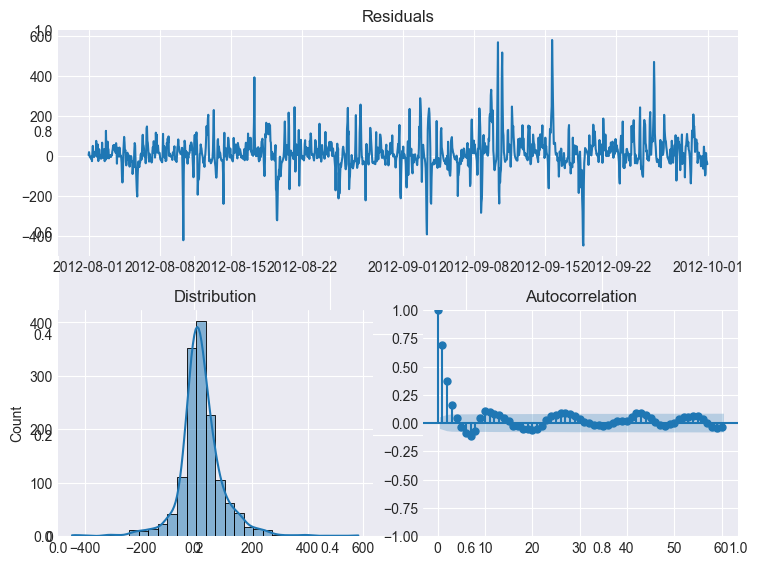

In [14]:
# Out-sample residuals distribution
# ==============================================================================
print(pd.Series(np.where(residuals < 0, 'negative', 'positive')).value_counts())
fig, ax = plt.subplots(figsize=(8, 6))
_ = plot_residuals(residuals=residuals, fig=fig)
fig.tight_layout()

In [15]:
# Store out-sample residuals in the forecaster
# ==============================================================================
forecaster.fit(y=data_train['users'], exog=data_train[exog_features])
forecaster.set_out_sample_residuals(residuals=residuals)

In [16]:
# Backtesting with prediction intervals in test data using out-sample residuals
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster          = forecaster,
                          y                   = data['users'], # Full dataset
                          exog                = data[exog_features],
                          steps               = 36,
                          metric              = 'mean_absolute_error',
                          initial_train_size  = len(data.loc[:end_validation]),
                          refit               = False,
                          interval            = [10, 90], # 80% prediction interval
                          n_boot              = 100,
                          in_sample_residuals = False, # Use out-sample residuals
                          binned_residuals    = False,
                          n_jobs              = 'auto',
                          verbose             = False,
                          show_progress       = True
                      )
predictions.head(5)

100%|██████████| 61/61 [00:25<00:00,  2.37it/s]


pred  lower_bound  upper_bound
2012-10-01 00:00:00  39.792324   -50.768237   110.215739
2012-10-01 01:00:00  17.103559   -50.829203   150.451199
2012-10-01 02:00:00  13.859449   -53.905096   162.693287
2012-10-01 03:00:00  12.616873   -85.636221   220.231940
2012-10-01 04:00:00   9.853097  -109.853429   202.366224

In [17]:
# Predicted interval coverage (on test data)
# ==============================================================================
inside_interval = np.where(
                      (data.loc[end_validation:, 'users'] >= predictions["lower_bound"]) & \
                      (data.loc[end_validation:, 'users'] <= predictions["upper_bound"]),
                      True,
                      False 
                  )

coverage = inside_interval.mean()
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = predictions['upper_bound'] - predictions['lower_bound']
area = area.sum()
print(f"Total area of the interval: {round(area, 2)}")

# Ploc
# ==============================================================================
plot_predicted_intervals(
    predictions=predictions,
    y_true=data_test,
    target_variable='users',
)

Predicted interval coverage: 85.58 %
Total area of the interval: 636189.93


The resulting prediction intervals derived from out-of-sample residuals show increased width compared to those generated using in-sample residuals. Interestingly, in this scenario, the true coverage exceeds the nominal coverage. Examining the plot, we see that the intervals are particularly wide when the predicted values are low. This is due to the fact that the out-of-sample residuals are selected at random, assuming that they are independent of the predicted values. This is not the case.

## Out sample residuals (conditioned on predicted values)

To account for the dependence between the residuals and the predicted values, the predicted values are passed to the `set_out_sample_residuals()` method in addition to the residuals. The binning process can be adjusted using the argument `binner_kwargs` of the forecast object.

In [18]:
# Backtesting on validation data to obtain out-sample residuals
# ==============================================================================
_, predictions_val = backtesting_forecaster(
                         forecaster         = forecaster,
                         y                  = data.loc[:end_validation, 'users'], # Train + Validation
                         exog               = data.loc[:end_validation, exog_features],
                         steps              = 36,
                         metric             = 'mean_absolute_error',
                         initial_train_size = len(data.loc[:end_train]),
                         refit              = False,
                         n_jobs             = 'auto',
                         verbose            = False,
                         show_progress      = True
                     )
residuals = data.loc[predictions_val.index, 'users'] - predictions_val['pred']
residuals = residuals.dropna()

# Store out-sample residuals in the forecaster 
# ==============================================================================
forecaster.fit(y=data_train['users'], exog=data_train[exog_features])
forecaster.set_out_sample_residuals(residuals=residuals, y_pred=predictions_val['pred'])

100%|██████████| 41/41 [00:00<00:00, 190.26it/s]


In [19]:
# Intervals of the residual binning
# ==============================================================================
pprint(forecaster.binner_intervals)

{0: (-135.1042763532065, 5.85425793910884),
 1: (5.85425793910884, 14.039541524218917),
 2: (14.039541524218917, 26.609755409486034),
 3: (26.609755409486034, 45.86178420544614),
 4: (45.86178420544614, 70.73367416035359),
 5: (70.73367416035359, 96.28362486447824),
 6: (96.28362486447824, 123.00665910756395),
 7: (123.00665910756395, 151.1438428629985),
 8: (151.1438428629985, 180.92478212916697),
 9: (180.92478212916697, 214.15844111899898),
 10: (214.15844111899898, 252.3058983676971),
 11: (252.3058983676971, 297.73819867593664),
 12: (297.73819867593664, 361.5285962246215),
 13: (361.5285962246215, 459.90612949624875),
 14: (459.90612949624875, 1011.655583898254)}


In [20]:
for k, v in forecaster.out_sample_residuals_by_bin.items():
    print(f" Bin {k}: n={len(v)}")

 Bin 0: n=55
 Bin 1: n=45
 Bin 2: n=67
 Bin 3: n=90
 Bin 4: n=82
 Bin 5: n=48
 Bin 6: n=36
 Bin 7: n=48
 Bin 8: n=67
 Bin 9: n=97
 Bin 10: n=84
 Bin 11: n=130
 Bin 12: n=155
 Bin 13: n=155
 Bin 14: n=200


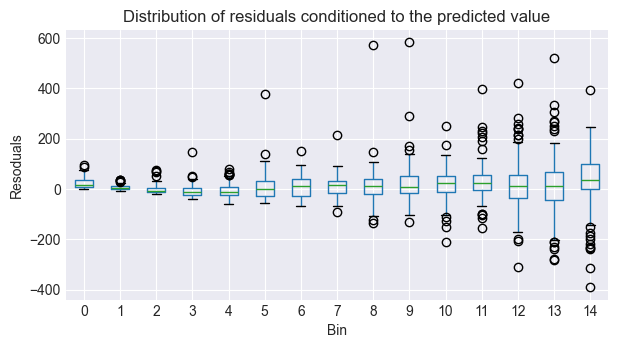

In [21]:
# Distribution of the residual per bin (boxplot)
# ==============================================================================
out_sample_residuals_by_bin_df = pd.DataFrame(
    dict([(k, pd.Series(v)) for k,v in forecaster.out_sample_residuals_by_bin.items()])
)
fig, ax = plt.subplots(figsize=(7, 3.5))
out_sample_residuals_by_bin_df.boxplot(ax=ax)
ax.set_title("Distribution of residuals conditioned to the predicted value")
ax.set_xlabel("Bin")
ax.set_ylabel("Resoduals");

In [22]:
# Backtesting with prediction intervals in test data using out-sample residuals
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster          = forecaster,
                          y                   = data['users'], # Full dataset
                          exog                = data[exog_features],
                          steps               = 36,
                          metric              = 'mean_absolute_error',
                          initial_train_size  = len(data.loc[:end_validation]),
                          refit               = False,
                          interval            = [10, 90], # 80% prediction interval
                          n_boot              = 100,
                          in_sample_residuals = False, # Use out-sample residuals
                          binned_residuals    = True,
                          n_jobs              = 'auto',
                          verbose             = False,
                          show_progress       = True
                      )
predictions.head(5)

100%|██████████| 61/61 [00:38<00:00,  1.60it/s]


pred  lower_bound  upper_bound
2012-10-01 00:00:00  39.792324     8.814805    60.174624
2012-10-01 01:00:00  17.103559    -0.583205    47.255851
2012-10-01 02:00:00  13.859449     4.183079    51.962813
2012-10-01 03:00:00  12.616873     5.581482    59.765871
2012-10-01 04:00:00   9.853097     6.702258    61.940776

In [23]:
# Predicted interval coverage (on test data)
# ==============================================================================
inside_interval = np.where(
                      (data.loc[end_validation:, 'users'] >= predictions["lower_bound"]) & \
                      (data.loc[end_validation:, 'users'] <= predictions["upper_bound"]),
                      True,
                      False 
                  )

coverage = inside_interval.mean()
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = predictions['upper_bound'] - predictions['lower_bound']
area = area.sum()
print(f"Total area of the interval: {round(area, 2)}")

# Ploc
# ==============================================================================
plot_predicted_intervals(
    predictions=predictions,
    y_true=data_test,
    target_variable='users',
)

Predicted interval coverage: 82.1 %
Total area of the interval: 550884.59


When using out-of-sample residuals conditioned on the predicted value, the coverage of the predicted intervals closely matches the nominal coverage. In addition, these intervals have a narrower range than those obtained using out-of-sample residuals not conditioned on the predicted value. This implies that the intervals achieve the desired coverage with reduced uncertainty.